In [28]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('science')
plt.rcParams['text.usetex'] = True
#import seaborn; seaborn.set()
import astropy.io.fits as fits
from astropy.io import ascii
from astropy.table import Table
import scipy.stats as stats
import os
import re
from pandas import DataFrame
import pandas as pd
import sys
# 定义颜色
colors = {
    'red': '#E24A33',
    'blue': '#348ABD',
    'green': '#8EBA42',
    'orange': '#FBC15E',
    'purple': '#988ED5',
    'pink': '#FFB5B8',
    'gray': '#777777'
}


def readfile(tfile): 
    with open(tfile,'r') as f:
        lines=f.readlines()
    return lines

In [29]:
source="/Volumes/WD_BLACK/Data/1A0535p262/HXMT/HHT/20201213_QPOphase/fit_results_fdcut"
path0="/Volumes/WD_BLACK/Data/1A0535p262/HXMT/HHT/20201213_QPOphase/fit_results_fdcut"
files=os.listdir("%s"%source)

In [30]:
# #two comptt
# Models=['gabs','gaussian','compTT','compTT']
# #Models=['compTT']
# N_Units=[[1,1],[0],[1,1,0,0],[1,1,0,0]]
# errs=[2,4,8,10,11,12,14,16,17,18,20]
# Long_index=[1,1,2,1]

#two comptt
# Models=['gabs','gaussian','thcomp','bbody','comptb']
# N_Units=[[1,1],[0],[0,1],[1,0],[1,0,0,0]]
# errs=[2,4,8,9,10,13,14,15,17,18,21]
# Long_index=[1,1,1,1,1]

Models=['gabs','gabs','gaussian','fdcut']
N_Units=[[1,1],[1,1,1],[0],[0,0,0]]
errs=[3,5,6,7,8,11,12,14,15]
Long_index=[2,1,1,1]

In [31]:
def read_fitresults(source,files,Models,N_Unitsi,path0):
    print(files)
    #MJD = read_MJD(files,path0)
    f = open("%s/%s"%(source,files),"r")
    all=f.read()
    #print(all)
    line_tails=readfile("%s/%s"%(source,files))
    j=0
    pars_values=[]
    pars_names=[]
    while j < len(Models):
        pars=re.findall(r"%s.*"%Models[j], all)
        #print(pars)
        l=len(N_Units[j])
        while l > 0:
            p=N_Units[j][-l]
            if Long_index[j] > 1:
                pars_values.append(float(pars[-l-(Long_index[j]-1)*len(N_Units[j+1])].split()[2+p]))
                name_str=Models[j]+'%s'%Long_index[j]+'_'+pars[-l].split()[1]
                pars_names.append(name_str)
                l-=1
            else:
                pars_values.append(float(pars[-l].split()[2+p]))
                name_str=Models[j]+'%s'%Long_index[j]+'_'+pars[-l].split()[1]
                pars_names.append(name_str)
                l-=1
        j+=1
    par_chi=re.findall(r"Test statistic : Chi-Squared.*", all)
    #print(par_chi[-1].split())
    dofall=re.findall(r"Null hypothesis probability.*", all)
    #print(dofall[-1].split())
    chi2=par_chi[-1].split()[4]
    # print(chi2)
    dof=dofall[-1].split()[6]
    # print(dof)
    red_chi2=float(chi2)/float(dof)
    # print(red_chi2)
    return pars_names, pars_values, red_chi2

In [32]:
def read_errs(source,files,errs,pars_names,pars_values):
    f = open("%s/%s"%(source,files),"r")
    all=f.read()
    #print(all)
    line_tails=readfile("%s/%s"%(source,files))
    Err=re.findall(r"Parameter   Credible Interval.*", all)
    l=0
    while l < len(line_tails):
        if Err[0] in line_tails[l]:
            L=l
        else:
            pass
        l+=1
    for e in errs:
        Errs_results=[line_tails[L+1+a].split() for a in range(len(errs))]
    pars_Err_lh=[]
    NE=0
    while NE < len(errs):
        err_low=float(Errs_results[NE][1])
        err_high=float(Errs_results[NE][2])
        pars_Err_lh.append([err_low,err_high])
        NE+=1
    #print(pars_values)
    #get err
    Np=0
    err_LR=[]
    while Np < len(pars_values):
        err_L=pars_values[Np]-pars_Err_lh[Np][0]
        err_R=pars_Err_lh[Np][1]-pars_values[Np]
        err_LR.append([err_L,err_R])
        Np+=1
    err_names_L=["%s_Lerrs"%Name for Name in pars_names]
    err_names_R=["%s_Rerrs"%Name for Name in pars_names]

    err_L=[i[0] for i in err_LR]
    err_R=[i[1] for i in err_LR]

    return err_names_L,err_L,err_names_R,err_R

In [33]:
i=0
red_chi2_all=[]
while i < len(files):
#while i < 1:
    #pars_names, pars_values,red_chi2,dof, MJD, Lum, Lum_errL, Lum_errR=read_fitresults(source,files[i],Models,N_Units,path0)
    pars_names, pars_values, red_chi2=read_fitresults(source,files[i],Models, N_Units,path0)
    red_chi2_all.append(red_chi2)
    #print(red_chi2)
    #print(pars_names)
    fit_names=pars_names
    fit_data=pars_values

    err_names_L, err_L, err_names_R, err_R=read_errs(source,files[i],errs,pars_names,pars_values)
    #print(err_names_L)
    #err_names_L, err_L = err_names_L+['Lum_errL'], err_L+[Lum_errL]
    #err_names_R, err_R = err_names_R+['Lum_errR'], err_R+[Lum_errR]
    
    derr_L=dict(zip(err_names_L,err_L))
    derr_R=dict(zip(err_names_R,err_R))
    if i==0:
        d1 = dict(zip(fit_names,fit_data))
        Para=pd.DataFrame(d1,index=['%s'%files[i]])
        Para_errL=pd.DataFrame(derr_L,index=['%s'%files[i]])
        Para_errR=pd.DataFrame(derr_R,index=['%s'%files[i]])
        i+=1
    else:
        Para.loc['%s'%files[i]]=fit_data
        Para_errL.loc['%s'%files[i]]=err_L
        Para_errR.loc['%s'%files[i]]=err_R
        i+=1
Para_all=pd.concat([Para,Para_errL,Para_errR],axis=1)
#save_data="fit_comptt_final.csv"
#Para_all.to_csv(save_data)

phase_0001.txt
phase_0102.txt
phase_0203.txt
phase_0304.txt
phase_0405.txt
phase_0506.txt
phase_0607.txt
phase_0708.txt
phase_0809.txt
phase_0910.txt


In [34]:
Para_all

,gabs2_Sigma,gabs2_Strength,gabs1_LineE,gabs1_Sigma,gabs1_Strength,gaussian1_norm,fdcut1_Gamma1,fdcut1_Efold,fdcut1_norm,gabs2_Sigma_Lerrs,...,fdcut1_norm_Lerrs,gabs2_Sigma_Rerrs,gabs2_Strength_Rerrs,gabs1_LineE_Rerrs,gabs1_Sigma_Rerrs,gabs1_Strength_Rerrs,gaussian1_norm_Rerrs,fdcut1_Gamma1_Rerrs,fdcut1_Efold_Rerrs,fdcut1_norm_Rerrs
phase_0001.txt,117.056,6.59329,48.9137,11.8882,16.17950,0.001835,0.597523,14.8438,1.18835,12.1720,...,0.00017,2.030,4.07111,1.2366,0.7599,1.26650,0.003646,0.028778,0.3585,0.04511
phase_0102.txt,110.809,8.40712,48.3472,11.8256,12.94710,0.006443,0.619976,15.0937,1.21244,11.7019,...,0.01007,7.227,5.53998,1.2257,1.1608,2.08100,0.001837,0.010992,0.2270,0.01938
phase_0203.txt,113.311,12.17120,46.6604,11.7661,9.82089,0.006016,0.620251,15.4919,1.20594,8.9670,...,0.03332,4.043,6.72750,0.5692,1.1120,1.55911,0.002245,0.008822,0.0788,0.01682
phase_0304.txt,108.324,14.63570,45.9283,12.8070,8.41757,0.009659,0.604379,16.0686,1.18550,4.5740,...,0.02835,5.694,7.57660,0.8881,1.1655,1.13738,0.002606,0.004558,0.1624,0.01053
phase_0405.txt,109.816,16.08490,44.6995,13.1224,8.24220,0.006573,0.583448,16.1736,1.16288,3.2420,...,0.02795,4.425,8.86900,0.6427,1.0719,0.71267,0.002277,0.012989,0.1672,0.02527
phase_0506.txt,111.784,20.54510,44.9977,12.9125,8.04877,0.005474,0.592967,16.3948,1.15895,3.5350,...,0.01971,5.485,12.53960,1.1798,1.6194,1.50869,0.003218,0.013649,0.1150,0.02108
phase_0607.txt,113.922,17.86770,45.8974,11.4270,8.62084,0.008992,0.631302,16.2766,1.22225,0.1920,...,0.02142,4.953,9.17770,0.5765,1.0753,1.06827,0.001188,0.002175,0.0818,0.00509
phase_0708.txt,109.026,10.50540,47.8083,12.1707,12.54980,0.007267,0.607553,15.7896,1.19434,5.3550,...,0.02133,3.768,4.85510,0.8560,1.0012,2.02110,0.002979,0.013894,0.2278,0.02028
phase_0809.txt,117.849,13.67030,48.3240,11.2298,14.29920,0.006853,0.593297,14.9929,1.21619,9.0320,...,0.02257,1.788,11.26590,0.4815,0.6105,1.16760,0.002035,0.011635,0.1423,0.01573
phase_0910.txt,110.117,4.71578,49.2527,11.6766,16.54700,0.007429,0.587433,14.7045,1.20231,10.3429,...,0.01080,5.132,6.82722,0.9558,0.6173,1.74900,0.003207,0.025027,0.2996,0.04491


In [35]:
red_chi2_all=np.array(red_chi2_all)
red_chi2_all

array([0.91595402, 0.91830189, 0.94832924, 1.02880893, 1.02289216,
       1.08758025, 1.00224138, 1.04050926, 0.92725446, 0.94754464])

In [36]:
# array([1.02469291, 1.04010963, 1.00483516, 0.98260734, 1.03002324,
#        1.00123267, 0.96921947, 1.0378577 , 1.0424181 , 1.03605942])
# array([1.05194988, 1.0372352 , 1.00356753, 1.00218944, 1.05700308,
#        1.01504215, 0.97053036, 1.04151538, 1.05785881, 1.04276827])
# array([1.12392801, 1.05589883, 1.00779251, 1.07849496, 1.1295535 ,
#        1.07886677, 0.97735023, 1.05447348, 1.11148837, 1.12940948])

In [37]:
print(Para_all.columns)
M=len(errs)
print(M)
names=Para_all.columns[:M]
print(names)

Index(['gabs2_Sigma', 'gabs2_Strength', 'gabs1_LineE', 'gabs1_Sigma',
       'gabs1_Strength', 'gaussian1_norm', 'fdcut1_Gamma1', 'fdcut1_Efold',
       'fdcut1_norm', 'gabs2_Sigma_Lerrs', 'gabs2_Strength_Lerrs',
       'gabs1_LineE_Lerrs', 'gabs1_Sigma_Lerrs', 'gabs1_Strength_Lerrs',
       'gaussian1_norm_Lerrs', 'fdcut1_Gamma1_Lerrs', 'fdcut1_Efold_Lerrs',
       'fdcut1_norm_Lerrs', 'gabs2_Sigma_Rerrs', 'gabs2_Strength_Rerrs',
       'gabs1_LineE_Rerrs', 'gabs1_Sigma_Rerrs', 'gabs1_Strength_Rerrs',
       'gaussian1_norm_Rerrs', 'fdcut1_Gamma1_Rerrs', 'fdcut1_Efold_Rerrs',
       'fdcut1_norm_Rerrs'],
      dtype='object')
9
Index(['gabs2_Sigma', 'gabs2_Strength', 'gabs1_LineE', 'gabs1_Sigma',
       'gabs1_Strength', 'gaussian1_norm', 'fdcut1_Gamma1', 'fdcut1_Efold',
       'fdcut1_norm'],
      dtype='object')


In [38]:
#20201213
phase_bins=np.array([0.0625737 , 0.12505472, 0.18753574, 0.25001676, 0.31249777,
        0.37497879, 0.43745981, 0.49994083, 0.56242185, 0.62490287,
        0.68738389, 0.74986491, 0.81234593, 0.87482695, 0.93730797,
        0.99978899, 1.0625737 , 1.12505472, 1.18753574, 1.25001676,
        1.31249777, 1.37497879, 1.43745981, 1.49994083, 1.56242185,
        1.62490287, 1.68738389, 1.74986491, 1.81234593, 1.87482695,
        1.93730797, 1.99978899])
profile=np.array([ 74.11247266,  76.96480527,  84.73580509,  94.67703538,
        109.28895194, 123.81972192, 137.04807947, 142.25929539,
        142.84224237, 137.44075638, 124.01116812, 109.68468293,
         97.98000585,  85.89430308,  77.67582055,  75.43592102,
         74.11247266,  76.96480527,  84.73580509,  94.67703538,
        109.28895194, 123.81972192, 137.04807947, 142.25929539,
        142.84224237, 137.44075638, 124.01116812, 109.68468293,
         97.98000585,  85.89430308,  77.67582055,  75.43592102])

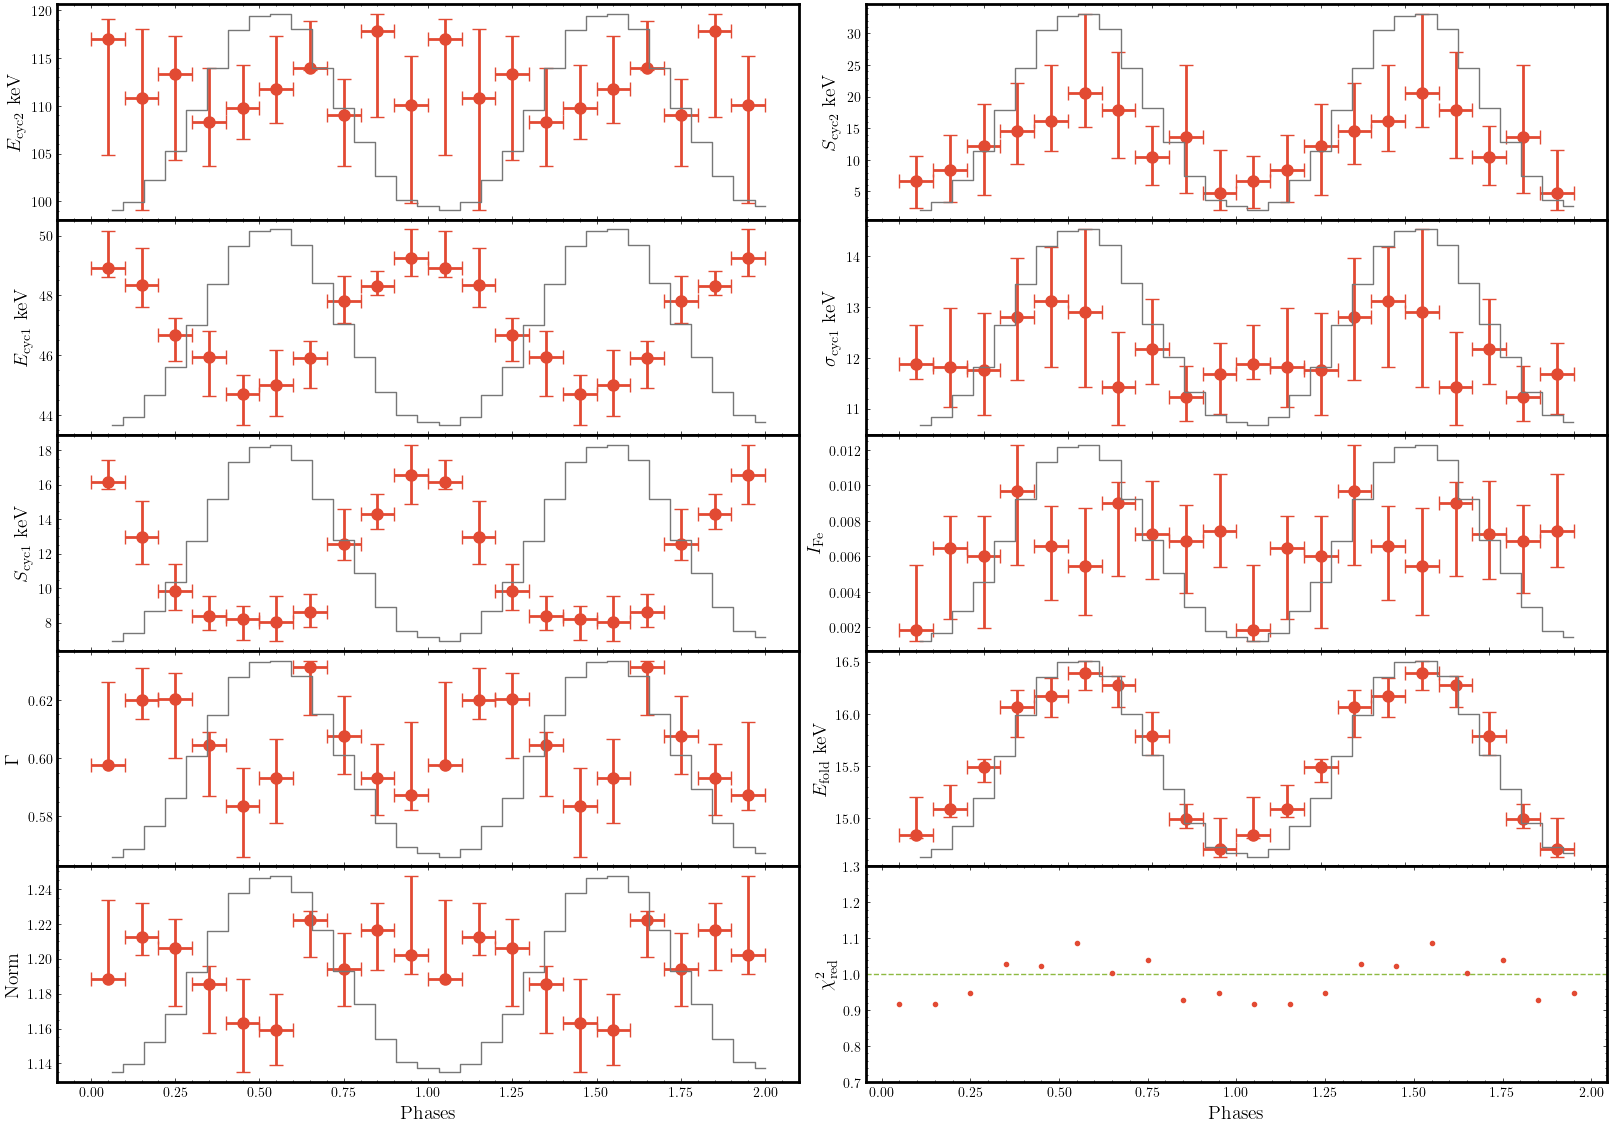

In [39]:
X = np.array([0.05,0.15,0.25,0.35,0.45,0.55,0.65,0.75,0.85,0.95])
x_data=np.hstack([X,X+1])
X_err=np.array([0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05])
x_err=np.hstack([X_err,X_err])
fig, axs = plt.subplots((M)//2+1, 2, figsize=(20, 14))
axs = axs.flatten()
#fig, axs = plt.subplots(M+1,1,figsize=(4, 16))
Ylabels=names
Ylabels=[r'$E_{\rm cyc2}$ keV',r'$S_{\rm cyc2}$ keV', 
         r'$E_{\rm cyc1}$ keV', r'$\sigma_{\rm cyc1}$ keV', r'$S_{\rm cyc1}$ keV', 
         r'$I_{\rm Fe}$', 
         r'$\Gamma$', r'$E_{\rm fold}$ keV', r'Norm']
i=0
while i < len(names):
    name=names[i]
    y1=Para_all['%s'%name].values
    #print(np.mean(y1))
    y1_err=[abs(Para_all['%s_Lerrs'%name].values),abs(Para_all['%s_Rerrs'%name].values)]
    y1=np.hstack([y1,y1])
    #y1=abs(y1)
    y1_err=np.hstack([y1_err,y1_err])
    y1_err=abs(y1_err)
    axs[0+i].errorbar(x_data, y1, xerr=x_err, yerr=y1_err, 
                      fmt='o', color=colors['red'], ecolor=colors['red'], capsize=5, markersize=8, elinewidth=2)
    axs2 = axs[0+i].twinx()
    axs2.errorbar(phase_bins, profile/np.mean(profile), 
                  drawstyle='steps-mid',color=colors['gray'],ecolor=colors['gray'])
    #axs2.errorbar(phase_bins2, profile2/np.mean(profile2), drawstyle='steps-mid',color='b',ecolor='b',alpha=0.5)
    axs2.set_yticks([])
    axs[0+i].set_ylabel(Ylabels[i],fontsize=14, fontweight='bold',fontname='Times New Roman')
    axs[i].spines['top'].set_linewidth(2)
    axs[i].spines['right'].set_linewidth(2)
    axs[i].spines['bottom'].set_linewidth(2)
    axs[i].spines['left'].set_linewidth(2)
    i+=1
#plot reduced chi^2 of fitting: 
axs[0+i].errorbar(x_data,np.hstack([red_chi2_all,red_chi2_all]),fmt='.',color=colors['red'],ecolor=colors['red'])
axs[0+i].axhline(y=1, color=colors['green'], linestyle='--',lw=1)
axs[0+i].set_ylim(0.7,1.3)
#axs[0+i].set_xlim(0.0,2.0)
#设置边框
axs[i].spines['top'].set_linewidth(2)
axs[i].spines['right'].set_linewidth(2)
axs[i].spines['bottom'].set_linewidth(2)
axs[i].spines['left'].set_linewidth(2)
# 移除最后一个子图
#fig.delaxes(axs[-1])
axs[-2].set_xlabel('Phases',fontsize=14, fontweight='bold',fontname='Times New Roman')
axs[0+i].set_ylim(0.7,1.3)
axs[0+i].set_ylabel(r'$\chi^2_{\rm red}$',fontsize=14, fontweight='bold',fontname='Times New Roman')
axs[0+i].set_xlabel('Phases',fontsize=14, fontweight='bold',fontname='Times New Roman')
plt.subplots_adjust(wspace=0.09,hspace=0)
#plt.savefig('/Users/kldsky/Desktop/1A0535_results/fdcut/20201213_fdcut.pdf')

In [40]:
for i in names:
    rms=100*(max(abs(Para_all[i].values))-(min(abs(Para_all[i].values))))/(abs(max(Para_all[i].values))+min(abs(Para_all[i].values)))
    K=np.mean(Para_all[i].values)
    #print('rms:',rms)
    print('mean:',i,K)

mean: gabs2_Sigma 112.2014
mean: gabs2_Strength 12.519649
mean: gabs1_LineE 47.08292000000001
mean: gabs1_Sigma 12.08259
mean: gabs1_Strength 11.567287
mean: gaussian1_norm 0.006654206
mean: fdcut1_Gamma1 0.6038129
mean: fdcut1_Efold 15.582999999999998
mean: fdcut1_norm 1.194915


chi2 (constant model): 74.87
Degrees of freedom (constant model): 19
chi2 (sin model): 1.85
Degrees of freedom (sin model): 16
F value: 210.10
p value: 4.658496e-13
Sigma: 7.14
P-value: 4.658496e-13


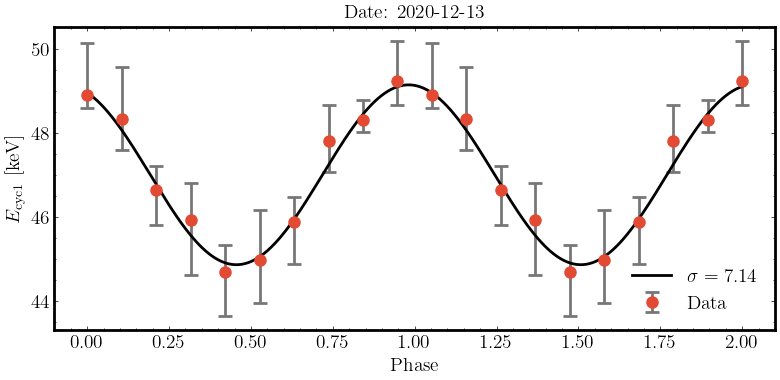

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import chi2
import scipy.stats as stats

# 定义常数函数和正弦函数
def const_func(x, C):
    return C

def sin_func(x, A, omega, phi, C):
    return A * np.cos(omega * x + phi) + C

# 数据
name0 = 'gabs1_LineE'
x = np.linspace(0, 2, 20)
# 这里需要使用实际数据集 Para_all，如果没有数据，可以用随机数据代替
y1 = Para_all['%s' % name0].values
y1_errL = abs(Para_all['%s_Lerrs' % name0].values)
y1_errR = abs(Para_all['%s_Rerrs' % name0].values)
# 示例数据
# y1 = np.random.rand(20)  # 请用实际数据替换
# y1_errL = np.random.rand(20) * 0.1  # 请用实际数据替换
# y1_errR = np.random.rand(20) * 0.1  # 请用实际数据替换

y1 = np.hstack([y1, y1])
y1_errL = np.hstack([y1_errL, y1_errL])
y1_errR = np.hstack([y1_errR, y1_errR])

y_edge1_MaxTau = y1
y_err_lower_edge1_MaxTau = y1_errL
y_err_upper_edge1_MaxTau = y1_errR
y_err_edge1_MaxTau = (y_err_lower_edge1_MaxTau + y_err_upper_edge1_MaxTau) / 2

# 常数函数拟合
params_const, _ = curve_fit(const_func, x, y_edge1_MaxTau, sigma=y_err_edge1_MaxTau, absolute_sigma=True)
y_fit_const = const_func(x, *params_const)
chi2_const = np.sum(((y_edge1_MaxTau - y_fit_const) / y_err_edge1_MaxTau) ** 2)
dof_const = len(y_edge1_MaxTau) - len(params_const)

# 正弦函数拟合
params_sin, params_covariance_sin = curve_fit(sin_func, x, y_edge1_MaxTau, sigma=y_err_edge1_MaxTau, absolute_sigma=True, 
                                              p0=[40, 2*np.pi, 0, 0.4])
y_fit_sin = sin_func(x, *params_sin)
chi2_sin = np.sum(((y_edge1_MaxTau - y_fit_sin) / y_err_edge1_MaxTau) ** 2)
dof_sin = len(y_edge1_MaxTau) - len(params_sin)

# 计算 F 值
F_value = ((chi2_const - chi2_sin) / (dof_const - dof_sin)) / (chi2_sin / dof_sin)

# 计算 p 值
p_value = 1 - stats.f.cdf(F_value, dof_const - dof_sin, dof_sin)

# 输出结果
print(f"chi2 (constant model): {chi2_const:.2f}")
print(f"Degrees of freedom (constant model): {dof_const}")
print(f"chi2 (sin model): {chi2_sin:.2f}")
print(f"Degrees of freedom (sin model): {dof_sin}")
print(f"F value: {F_value:.2f}")
print(f"p value: {p_value:.6e}")  # 使用科学计数法显示非常小的p值

# 计算 Z 分数（标准差数）
z_score = stats.norm.ppf(1 - p_value)  # 使用 1 - p_value 计算Z分数

# 使用更多的点使得拟合线条更平滑
x_smooth = np.linspace(0, 2, 400)
y_fit_smooth_sin = sin_func(x_smooth, *params_sin)

# 绘制拟合结果图像
fig, ax = plt.subplots(figsize=(8, 4))

# 绘制数据点和误差棒
ax.errorbar(x, y_edge1_MaxTau, yerr=[y_err_lower_edge1_MaxTau, y_err_upper_edge1_MaxTau], fmt='o', label='Data', color=colors['red'], ecolor=colors['gray'], elinewidth=2, capsize=5, capthick=2, markersize=8)

# 添加 sigma 值的文本
textstr = r'$\sigma=%.2f$' % (z_score, )

# 绘制平滑后的拟合正弦波
ax.plot(x_smooth, y_fit_smooth_sin, label=textstr, color='black', linewidth=2)


# 设置文本框的外观
#props = dict(boxstyle='round', facecolor='white', alpha=0.5)
#ax.text(0.25, 0.95, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top')

# 设置标签和标题
ax.set_xlabel('Phase', fontsize=14, fontweight='bold',fontname='Times New Roman')
ax.set_ylabel(r'$E_{\rm cyc1}$ [keV]', fontsize=14, fontweight='bold',fontname='Times New Roman')
# 显示图例
ax.legend(loc='lower right', fontsize=14)

# 去掉网格
ax.grid(False)

# 调整刻度和刻度标签
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_title('Date: 2020-12-13', fontsize=14, fontweight='bold',fontname='Times New Roman')
# 美化图形外观
fig.tight_layout()
# 保存图像为PDF（如需要）
#fig.savefig("/Users/kldsky/Desktop/1A0535_results/fdcut/20201213_fdcut_sigma.pdf")
print(f"Sigma: {z_score:.2f}")
print(f"P-value: {p_value:.6e}")

In [42]:
print(np.mean(Para_all['%s' % name0].values))
print(np.max(Para_all['%s' % name0].values))
print(np.min(Para_all['%s' % name0].values))

47.08292000000001
49.2527
44.6995


In [43]:
print([np.array(Para_all['%s' % name0].values)])
print([Para_all['%s_Lerrs' % name0].values,Para_all['%s_Rerrs' % name0].values])

[array([48.9137, 48.3472, 46.6604, 45.9283, 44.6995, 44.9977, 45.8974,
       47.8083, 48.324 , 49.2527])]
[array([0.3048, 0.7473, 0.8494, 1.2974, 1.0544, 1.0421, 0.9953, 0.7382,
       0.2997, 0.5879]), array([1.2366, 1.2257, 0.5692, 0.8881, 0.6427, 1.1798, 0.5765, 0.856 ,
       0.4815, 0.9558])]
